<a href="https://colab.research.google.com/github/Bast-94/ASL-PW/blob/main/TP_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Auto-encodeurs variationnels

Dans ce TP, dans un premier temps, nous allons entraîner un modèle génératif de type d'auto-encodeur variationnel sur le jeu de données MNIST (chiffres manuscrits de 0 à 9). Dans un deuxième, temps nous allons essayer de générer des chiffres en échantiollannant dans l'espace latent.

In [83]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Définir l'architecture du VAE
class VAE(nn.Module):
    def __init__(self, latent_dim: int = 50):
        super(VAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, 400)
        self.latent_dim = latent_dim
        self.fc21 = nn.Linear(400, self.latent_dim)  # Moyenne mu
        self.fc22 = nn.Linear(400, self.latent_dim)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(self.latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Entraînement du modèle
def train_vae(vae: VAE,optimizer, loss, train_loader):
  for epoch in range(10):
      vae.train()
      train_loss = 0
      for data, _ in train_loader:
          data = data.to(device)
          optimizer.zero_grad()
          recon_batch, mu, logvar = vae(data)
          loss = loss_function(recon_batch, data, mu, logvar)
          loss.backward()
          train_loss += loss.item()
          optimizer.step()

      print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 0, Loss: 169.64794638671876
Epoch 1, Loss: 126.69600846354167
Epoch 2, Loss: 117.23597223307291
Epoch 3, Loss: 113.04743995768229
Epoch 4, Loss: 110.7874154296875
Epoch 5, Loss: 109.21589488932291
Epoch 6, Loss: 108.12948712565104
Epoch 7, Loss: 107.44494767252604
Epoch 8, Loss: 106.77770159505208
Epoch 9, Loss: 106.29638255208333


In [27]:
vae(next(iter(train_loader))[0])[0].size()

torch.Size([128, 784])

## Exercices

* Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.
* Changer la dimension de l'espace latent.
* Changer l'architecture du VAE.
* Paramétrer la fonction loss pour pondérer les deux termes (reconstruction et régularisation).
* Optionnel : entraîner le modèle sur un autre dataset.

### Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.

In [28]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=50, bias=True)
  (fc22): Linear(in_features=400, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

In [77]:
def sample_from_latent_space(vae: VAE):
  noised = torch.randn(1,400)
  mu, logvar = vae.fc21(noised), vae.fc22(noised)
  z = torch.randn(50)
  return vae.decode(z).view(28,28)

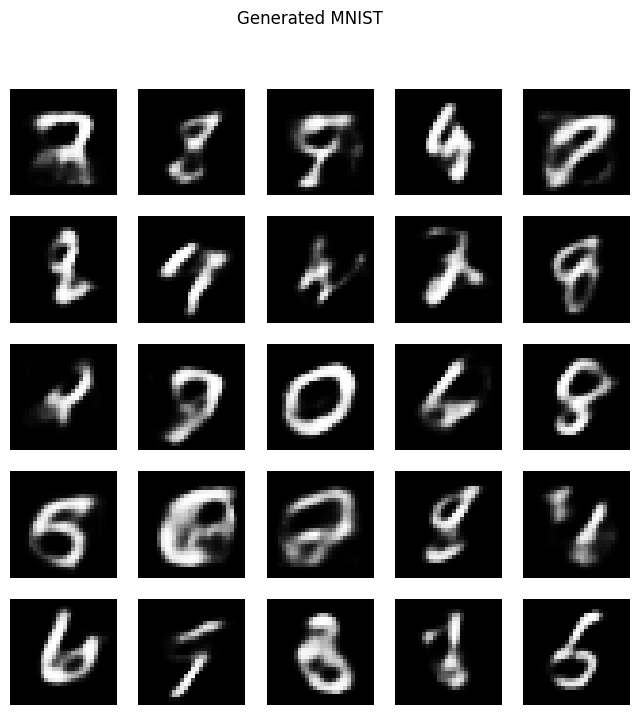

In [85]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

transform = T.ToPILImage()
col,row = 5,5
full_size = col*row
fig = plt.figure(figsize=(8,8))
fig.suptitle("Generated MNIST")
for i in range(full_size):
  ax = fig.add_subplot(row,col,i+1)
  tensor_img = sample_from_latent_space(vae)
  img = transform(tensor_img)
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

fig.savefig('generated_img.png')


### Changer la dimension de l'espace latent.

In [ ]:
alternate_vae = VAE